# Long-Horizon Prediction with Persistent Signals

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
SHEET_RETS = 'returns'
SHEET_METRICS = 'metrics'
rets = pd.read_excel("../data/crsp_market_data.xlsx", sheet_name=SHEET_RETS, index_col=0, parse_dates=True)
metrics = pd.read_excel("../data/crsp_market_data.xlsx", sheet_name=SHEET_METRICS, index_col=0, parse_dates=True)


In [ ]:
HORZ = 5  # number of years; change this to desired horizon
FREQ = 12  # number of months per year

months = HORZ * FREQ

KEY_RETS = f'{HORZ}-year rets'
KEY_METRICS = 'dp annual'

In [ ]:
data = pd.concat([rets['rets'], metrics['dp ratio']], axis=1)
data['dp annual'] = data['dp ratio'].rolling(window=FREQ).sum()
data['rets t+H'] = data['rets'].rolling(window=months).apply(lambda x: (x + 1).prod() - 1, raw=False)

#data['dp lag'] = data['dp smooth'].shift(months)
data[KEY_RETS] = data['rets t+H'].shift(-months)

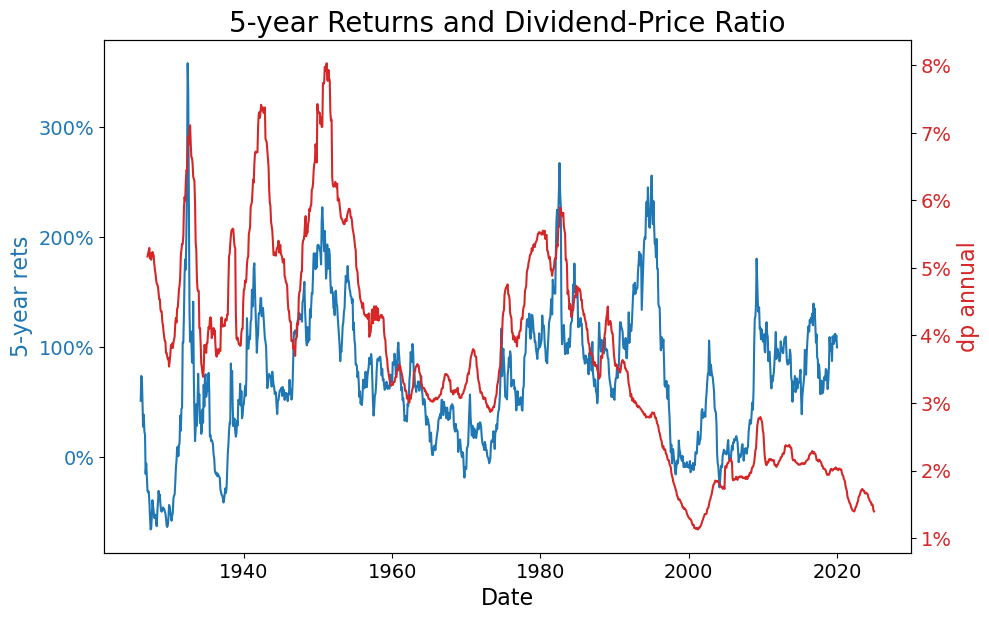

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig, ax1 = plt.subplots(figsize=(10, 6))

label_fontsize = 16
tick_fontsize = 14
title_fontsize = 20

percent_formatter = FuncFormatter(lambda x, pos: '{:.0f}%'.format(x * 100))

color1 = 'tab:blue'
ax1.set_xlabel('Date', fontsize=label_fontsize)
ax1.set_ylabel(KEY_RETS, color=color1, fontsize=label_fontsize)
ax1.plot(data.index, data[KEY_RETS], color=color1, label=KEY_RETS)
ax1.tick_params(axis='y', labelcolor=color1, labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)
ax1.yaxis.set_major_formatter(percent_formatter)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel(KEY_METRICS, color=color2, fontsize=label_fontsize)
ax2.plot(data.index, data[KEY_METRICS], color=color2, label=KEY_METRICS)
ax2.tick_params(axis='y', labelcolor=color2, labelsize=tick_fontsize)
ax2.yaxis.set_major_formatter(percent_formatter)

fig.tight_layout()
plt.title(f'{HORZ}-year Returns and Dividend-Price Ratio', fontsize=title_fontsize)
plt.show()

In [ ]:
corr_rets_dp = data[KEY_RETS].corr(data[KEY_METRICS])
print(f'Correlation: {corr_rets_dp:.0%}')

Correlation: 39%


In [ ]:
import statsmodels.api as sm
import pandas as pd
from IPython.display import display

# Remove NaN values for regression
reg_data = data[[KEY_RETS, KEY_METRICS]].dropna()

# Prepare data for regression
Y = reg_data[KEY_RETS]
X = reg_data[KEY_METRICS]

# Add constant to X for intercept
X_with_const = sm.add_constant(X)

# Run OLS regression
model = sm.OLS(Y, X_with_const)
results = model.fit()

# Extract key statistics
alpha = results.params['const']
beta = results.params[KEY_METRICS]
r_squared = results.rsquared
t_stat_beta = results.tvalues[KEY_METRICS]
p_value_beta = results.pvalues[KEY_METRICS]

# Prepare main summary dataframe (alpha, beta, r-squared)
summary_df = pd.DataFrame([
    [f"{alpha:.0%}", f"{beta:.1f}", f"{r_squared:.0%}"]
], columns=["alpha", "beta", "r-squared"], index=["OLS estimate"]).T

# Prepare t-stat and p-value dataframe for beta
beta_stats_df = pd.DataFrame(
    [ [f"{t_stat_beta:.1f}"], [f"{p_value_beta:.0%}"] ],
    columns=["beta"], 
    index=["t-stat", "p-value"]
)

display(summary_df)
display(beta_stats_df)


,OLS estimate
alpha,12%
beta,15.9
r-squared,15%


,beta
t-stat,14.2
p-value,0%


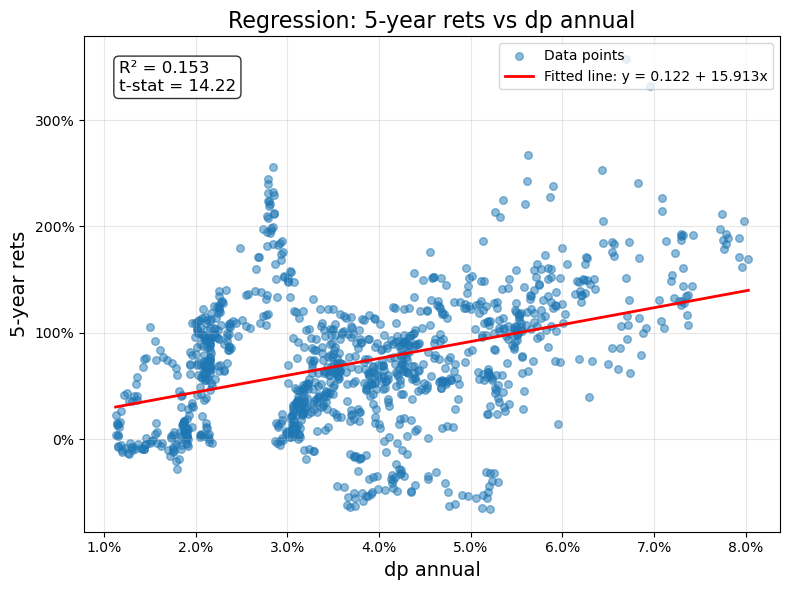

In [ ]:
# Create scatter plot with regression line
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot
ax.scatter(X, Y, alpha=0.5, s=30, label='Data points')

# Add regression line
X_plot = np.linspace(X.min(), X.max(), 100)
Y_pred = alpha + beta * X_plot
ax.plot(X_plot, Y_pred, 'r-', linewidth=2, label=f'Fitted line: y = {alpha:.3f} + {beta:.3f}x')

# Format axes
ax.set_xlabel(KEY_METRICS, fontsize=14)
ax.set_ylabel(KEY_RETS, fontsize=14)
ax.set_title(f'Regression: {KEY_RETS} vs {KEY_METRICS}', fontsize=16)

# Add grid
ax.grid(True, alpha=0.3)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.0f}%'.format(x * 100)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.1f}%'.format(x * 100)))

# Add legend with regression statistics
legend_text = f'R² = {r_squared:.3f}\nt-stat = {t_stat_beta:.2f}'
ax.text(0.05, 0.95, legend_text, 
        transform=ax.transAxes, 
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Various Horizons

In [ ]:
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Define the horizons to analyze (in years)
horizons = [1/12,.25,.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize dictionaries to store results
results_estimates = {}
results_tstats = {}
results_pvalues = {}

# Loop over each horizon
for HORZ in horizons:
    
    # Calculate the number of months
    months = round(HORZ * FREQ)
    
    # Prepare the data for this horizon
    data_temp = pd.concat([rets['rets'], metrics['dp ratio']], axis=1)
    data_temp['dp annual'] = data_temp['dp ratio'].rolling(window=FREQ).sum()
    data_temp['rets t+H'] = data_temp['rets'].rolling(window=months).apply(lambda x: (x + 1).prod() - 1, raw=False)
    data_temp[f'{HORZ}-year rets'] = data_temp['rets t+H'].shift(-months)
    
    # Set up regression variables
    key_rets_temp = f'{HORZ}-year rets'
    key_metrics_temp = 'dp annual'
    
    # Remove NaN values for regression
    reg_data = data_temp[[key_rets_temp, key_metrics_temp]].dropna()
    
    # Skip if not enough data
    if len(reg_data) < 30:  # Minimum observations for reasonable regression
        continue
    
    # Prepare data for regression
    Y = reg_data[key_rets_temp]
    X = reg_data[key_metrics_temp]
    
    # Add constant to X for intercept
    X_with_const = sm.add_constant(X)
    
    # Run OLS regression
    model = sm.OLS(Y, X_with_const)
    results = model.fit()
    
    # Store estimates
    results_estimates[HORZ] = {
        'Alpha': results.params['const'],
        'Beta': results.params[key_metrics_temp],
        'R-squared': results.rsquared,
        'N': len(reg_data)
    }
    
    # Store t-statistics
    results_tstats[HORZ] = {
        'Alpha t-stat': results.tvalues['const'],
        'Beta t-stat': results.tvalues[key_metrics_temp]
    }
    
    # Store p-values
    results_pvalues[HORZ] = {
        'Alpha p-value': results.pvalues['const'],
        'Beta p-value': results.pvalues[key_metrics_temp]
    }
    
    print(f"Completed horizon: {HORZ} years (N={len(reg_data)} observations)")

print("\nAll horizons processed successfully!")


Completed horizon: 0.08333333333333333 years (N=1176 observations)
Completed horizon: 0.25 years (N=1174 observations)
Completed horizon: 0.5 years (N=1171 observations)
Completed horizon: 1 years (N=1165 observations)
Completed horizon: 2 years (N=1153 observations)
Completed horizon: 3 years (N=1141 observations)
Completed horizon: 4 years (N=1129 observations)
Completed horizon: 5 years (N=1117 observations)
Completed horizon: 6 years (N=1105 observations)
Completed horizon: 7 years (N=1093 observations)
Completed horizon: 8 years (N=1081 observations)
Completed horizon: 9 years (N=1069 observations)
Completed horizon: 10 years (N=1057 observations)

All horizons processed successfully!


In [ ]:
from IPython.display import display, HTML

In [ ]:
# Create DataFrame for estimates
df_estimates = pd.DataFrame(results_estimates).T
df_estimates.index.name = 'Horizon (Years)'

# Create DataFrame combining t-stats and p-values
df_tstats = pd.DataFrame(results_tstats).T
df_pvalues = pd.DataFrame(results_pvalues).T

# Combine t-stats and p-values into one dataframe
df_stats = pd.DataFrame(index=df_tstats.index)
df_stats.index.name = 'Horizon (Years)'
df_stats['Alpha t-stat'] = df_tstats['Alpha t-stat']
df_stats['Alpha p-value'] = df_pvalues['Alpha p-value']
df_stats['Beta t-stat'] = df_tstats['Beta t-stat']
df_stats['Beta p-value'] = df_pvalues['Beta p-value']

# # Display DataFrame 1: Estimates
# display(HTML("<h3>Regression Estimates Across Horizons</h3>"))
# display(df_estimates.round(4))


In [ ]:
# display(HTML("<h3>T-Statistics and P-Values Across Horizons</h3>"))
# display(df_stats.round(4))


In [ ]:
# Create a summary DataFrame (raw values, no formatting/scaling)
summary_df = pd.DataFrame()
summary_df['Alpha'] = df_estimates['Alpha']
summary_df['Beta'] = df_estimates['Beta']
summary_df['R²'] = df_estimates['R-squared']
summary_df['Beta t-stat'] = df_stats['Beta t-stat']
summary_df['Significant?'] = df_stats['Beta p-value'] < 0.05  # 5% significance level
summary_df['N obs'] = df_estimates['N'].astype(int)

# Set index to formatted string (1 decimal) for horizon
summary_df.index = summary_df.index.map(lambda x: f"{x:.1f}")

# Display the summary DataFrame with formatting using .style
display(HTML("<h3>Summary: Dividend-Price Ratio Predictive Power Across Horizons</h3>"))
display(
    summary_df.style
        .format({
            'Alpha': '{:.1%}',
            'Beta': '{:.1f}',
            'R²': '{:.1%}',
            'Beta t-stat': '{:.1f}',
            'N obs': '{:d}'
        })
        .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
        .set_properties(subset=['Alpha','Beta','R²','Beta t-stat', 'Significant?','N obs'], **{'text-align': 'center'})
)


,Alpha,Beta,R²,Beta t-stat,Significant?,N obs
Horizon (Years),,,,,,
0.1,0.2%,0.2,0.4%,2.1,True,1176
0.2,0.4%,0.7,1.2%,3.7,True,1174
0.5,0.9%,1.4,2.3%,5.3,True,1171
1.0,1.4%,2.9,4.6%,7.5,True,1165
2.0,5.3%,5.3,7.1%,9.4,True,1153
3.0,7.7%,8.3,10.5%,11.6,True,1141
4.0,8.0%,12.4,13.6%,13.3,True,1129
5.0,12.2%,15.9,15.3%,14.2,True,1117
6.0,18.5%,19.3,17.2%,15.1,True,1105


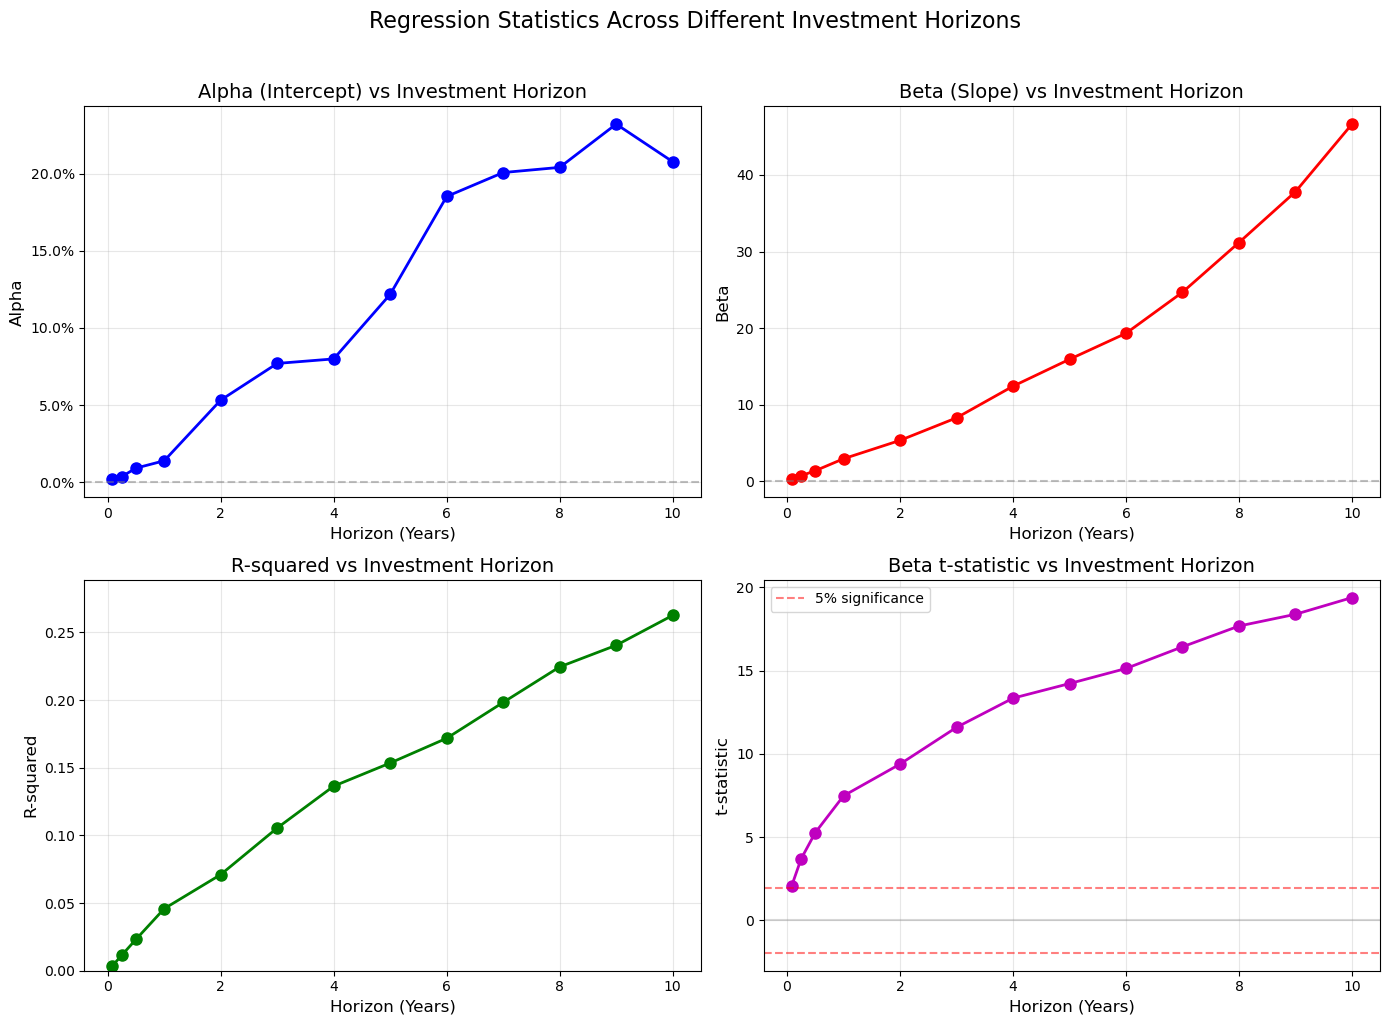

In [ ]:
# Create visualizations of how regression statistics change with horizon
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Alpha across horizons
ax1 = axes[0, 0]
ax1.plot(df_estimates.index, df_estimates['Alpha'], 'bo-', linewidth=2, markersize=8)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Horizon (Years)', fontsize=12)
ax1.set_ylabel('Alpha', fontsize=12)
ax1.set_title('Alpha (Intercept) vs Investment Horizon', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.1f}%'.format(x * 100)))

# Plot 2: Beta across horizons
ax2 = axes[0, 1]
ax2.plot(df_estimates.index, df_estimates['Beta'], 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Horizon (Years)', fontsize=12)
ax2.set_ylabel('Beta', fontsize=12)
ax2.set_title('Beta (Slope) vs Investment Horizon', fontsize=14)
ax2.grid(True, alpha=0.3)

# Plot 3: R-squared across horizons
ax3 = axes[1, 0]
ax3.plot(df_estimates.index, df_estimates['R-squared'], 'go-', linewidth=2, markersize=8)
ax3.set_xlabel('Horizon (Years)', fontsize=12)
ax3.set_ylabel('R-squared', fontsize=12)
ax3.set_title('R-squared vs Investment Horizon', fontsize=14)
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0, max(df_estimates['R-squared']) * 1.1])

# Plot 4: Beta t-statistics across horizons
ax4 = axes[1, 1]
ax4.plot(df_stats.index, df_stats['Beta t-stat'], 'mo-', linewidth=2, markersize=8)
ax4.axhline(y=1.96, color='red', linestyle='--', alpha=0.5, label='5% significance')
ax4.axhline(y=-1.96, color='red', linestyle='--', alpha=0.5)
ax4.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax4.set_xlabel('Horizon (Years)', fontsize=12)
ax4.set_ylabel('t-statistic', fontsize=12)
ax4.set_title('Beta t-statistic vs Investment Horizon', fontsize=14)
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.suptitle('Regression Statistics Across Different Investment Horizons', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


***

## Autoregression of the Dividend-Price Ratio

Now we examine the persistence of the dividend-price ratio by running an autoregression (AR(1) model):

**x(t) = alpha + beta × x(t-1) + error(t)**

where x(t) is the dividend-price ratio at time t.

In [ ]:
import statsmodels.api as sm
import pandas as pd
from IPython.display import display

# Prepare data for autoregression
ar_data = data[['dp annual']].dropna().copy()

# Create lagged variable (one-step ahead)
ar_data['dp annual lagged'] = ar_data['dp annual'].shift(1)

# Remove rows with NaN (from lagging)
ar_data = ar_data.dropna()

# Set up regression: x(t) = alpha + beta * x(t-1) + epsilon
Y = ar_data['dp annual']
X = ar_data['dp annual lagged']

# Add constant for intercept
X_with_const = sm.add_constant(X)

# Run OLS regression
ar_model = sm.OLS(Y, X_with_const)
ar_results = ar_model.fit()

# Extract key statistics
ar_alpha = ar_results.params['const']
ar_beta = ar_results.params['dp annual lagged']
ar_r_squared = ar_results.rsquared
ar_t_stat_alpha = ar_results.tvalues['const']
ar_t_stat_beta = ar_results.tvalues['dp annual lagged']
ar_p_value_alpha = ar_results.pvalues['const']
ar_p_value_beta = ar_results.pvalues['dp annual lagged']

# Create main results dataframe
ar_main_results = pd.DataFrame([
    [f"{ar_alpha:.6f}", f"{ar_beta:.6f}", f"{ar_r_squared:.4f}", len(ar_data)]
], columns=["Alpha", "Beta", "R-squared", "N"], index=["AR(1) Estimates"])

# Create t-statistics and p-values dataframe
ar_stats_results = pd.DataFrame([
    [f"{ar_t_stat_alpha:.3f}", f"{ar_t_stat_beta:.3f}"],
    [f"{ar_p_value_alpha:.4f}", f"{ar_p_value_beta:.4f}"]
], columns=["Alpha", "Beta"], index=["t-statistic", "p-value"])

# Display results
display(ar_main_results)
display(ar_stats_results)


,Alpha,Beta,R-squared,N
AR(1) Estimates,0.000035,0.998179,0.9953,1176


,Alpha,Beta
t-statistic,0.437,497.362
p-value,0.6623,0.0000


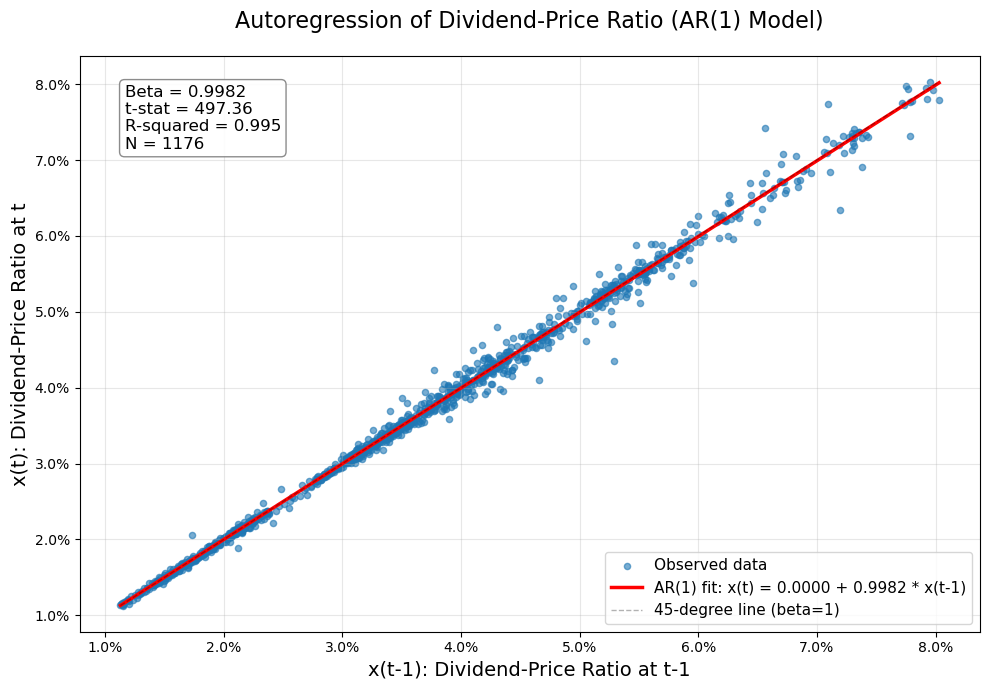

In [ ]:
# Visualization of the autoregression
fig, ax = plt.subplots(figsize=(10, 7))

# Scatter plot
ax.scatter(X, Y, alpha=0.6, s=20, label='Observed data')

# Add regression line
X_plot = np.linspace(X.min(), X.max(), 100)
Y_pred = ar_alpha + ar_beta * X_plot
ax.plot(X_plot, Y_pred, 'r-', linewidth=2.5, label=f'AR(1) fit: x(t) = {ar_alpha:.4f} + {ar_beta:.4f} * x(t-1)')

# Add 45-degree line for reference (perfect persistence would be beta=1)
min_val = min(X.min(), Y.min())
max_val = max(X.max(), Y.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, linewidth=1, label='45-degree line (beta=1)')

# Format axes
ax.set_xlabel('x(t-1): Dividend-Price Ratio at t-1', fontsize=14)
ax.set_ylabel('x(t): Dividend-Price Ratio at t', fontsize=14)
ax.set_title('Autoregression of Dividend-Price Ratio (AR(1) Model)', fontsize=16, pad=20)

# Format axes as percentage
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.1f}%'.format(x * 100)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.1f}%'.format(x * 100)))

# Add grid
ax.grid(True, alpha=0.3)

# Add statistics box
stats_text = f'Beta = {ar_beta:.4f}\nt-stat = {ar_t_stat_beta:.2f}\nR-squared = {ar_r_squared:.3f}\nN = {len(ar_data)}'
ax.text(0.05, 0.95, stats_text, 
        transform=ax.transAxes, 
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.9))

ax.legend(loc='lower right', fontsize=11)
plt.tight_layout()
plt.show()
